In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with = engine)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
station = base.classes.station

measurement = base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [22]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23',)

In [57]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent_date = most_recent_date[0]
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
last_year = most_recent_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_scores_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_scores_df = precipitation_scores_df.sort_values(by='Date')
precipitation_scores_df


,Date,Precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


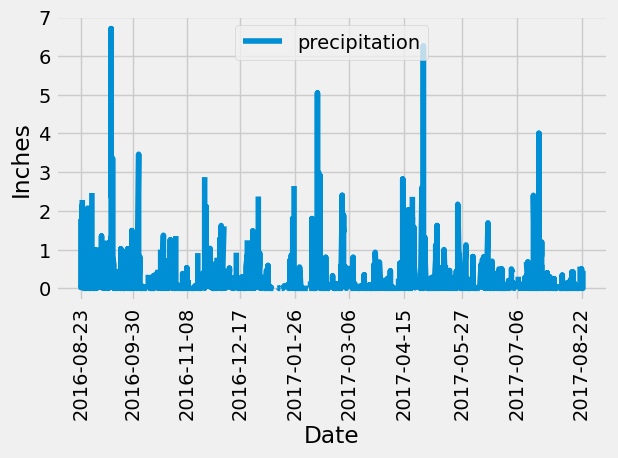

In [58]:

# Use Pandas Plotting with Matplotlib to plot the data

plt.figure()
plt.plot(precipitation_scores_df['Date'], precipitation_scores_df['Precipitation'], label='precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.yticks(np.arange(0, precipitation_scores_df['Precipitation'].max() + 1, 1))
plt.xticks(rotation=90)
step_size = len(precipitation_scores_df)//9
plt.xticks(precipitation_scores_df['Date'][::step_size], precipitation_scores_df['Date'][::step_size])
plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()

In [59]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_scores_df.describe()
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [60]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(station).count()
total_stations

9

In [61]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order. #CHATGPT ASSISTED
from sqlalchemy import func, desc
active_stations = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(desc(func.count(measurement.station))).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [62]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature. #GPT ASSISTED
most_active_station_id = active_stations[0][0] 
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == most_active_station_id).all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

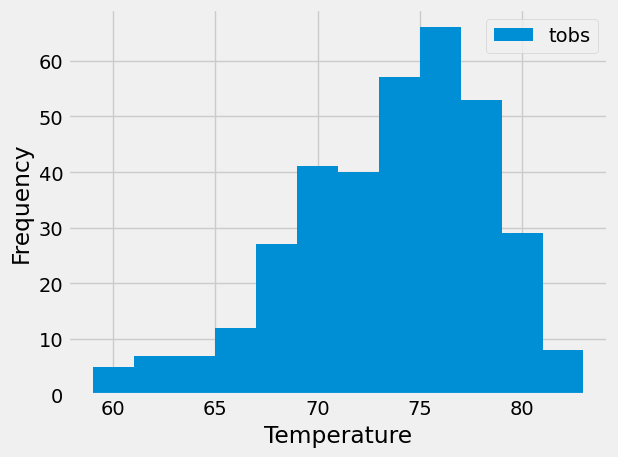

In [64]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.tobs).filter(measurement.station == most_active_station_id).filter(measurement.date >= last_year).all()
temperatures = [temp[0] for temp in temperature_data]
plt.figure()
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

# Close Session

In [65]:
# Close Session
session.close()